In [ ]:
import pandas as pd

def processar_arquivo_individual_saeb(filepath, ano):
    print(f"Processando arquivo: {filepath} para o ano {ano}...")
    
    colunas_originais = []
    mapa_para_padrao = {}
    separador = ';'
    
    if ano in [2021, 2019]:
        colunas_originais = ['ID_REGIAO', 'ID_SERIE', 'IN_PUBLICA', 'ID_LOCALIZACAO', 'IN_PRESENCA_MT', 'IN_PREENCHIMENTO_MT', 'PROFICIENCIA_MT_SAEB']
        mapa_para_padrao = {'ID_REGIAO': 'REGIAO_ID', 'ID_SERIE': 'SERIE_ID', 'IN_PUBLICA': 'REDE_ID', 'PROFICIENCIA_MT_SAEB': 'PROFICIENCIA'}
    elif ano == 2017:
        separador = ','
        colunas_originais = ['ID_REGIAO', 'ID_SERIE', 'IN_PUBLICA', 'ID_LOCALIZACAO', 'IN_PRESENCA_PROVA', 'IN_PREENCHIMENTO_PROVA', 'PROFICIENCIA_MT_SAEB']
        mapa_para_padrao = {'ID_REGIAO': 'REGIAO_ID', 'ID_SERIE': 'SERIE_ID', 'IN_PUBLICA': 'REDE_ID', 'PROFICIENCIA_MT_SAEB': 'PROFICIENCIA'}

    try:
        df = pd.read_csv(filepath, sep=separador, encoding='latin-1', usecols=colunas_originais, low_memory=False)
        df.rename(columns=mapa_para_padrao, inplace=True)

        if ano in [2021, 2019]:
            df = df.query("IN_PRESENCA_MT == 1 and IN_PREENCHIMENTO_MT == 1").copy()
        elif ano == 2017:
            df = df.query("IN_PRESENCA_PROVA == 1 and IN_PREENCHIMENTO_PROVA == 1").copy()
        
        df.dropna(subset=['PROFICIENCIA'], inplace=True)
        
        df['REDE'] = df['REDE_ID'].map({0: 'Privada', 1: 'Pública'})
        df['REGIAO'] = df['REGIAO_ID'].map({1: 'Norte', 2: 'Nordeste', 3: 'Sudeste', 4: 'Sul', 5: 'Centro-Oeste'})
        
        mapa_serie_corrigido = {5: '5º Ano EF', 9: '9º Ano EF', 12: '3ª Série EM', 13: '3ª Série EM'}
        df['SERIE'] = df['SERIE_ID'].map(mapa_serie_corrigido)
        
        df['ANO'] = ano
        
        colunas_finais = ['ANO', 'REGIAO', 'SERIE', 'REDE', 'PROFICIENCIA']
        return df[colunas_finais]

    except Exception as e:
        print(f"!!! Erro ao processar o arquivo {filepath}: {e}")
        return None


In [21]:
arquivos_2021 = [
    r'2021\TS_ALUNO_5EF.csv',
    r'2021\TS_ALUNO_9EF.csv',
    r'2021\TS_ALUNO_3EM.csv'
]
arquivos_2019 = [
    r'2019\TS_ALUNO_5EF.csv',
    r'2019\TS_ALUNO_9EF.csv',
    r'2019\TS_ALUNO_3EM.csv'
]
arquivos_2017 = [
    r'2017\TS_ALUNO_5EF.csv',
    r'2017\TS_ALUNO_9EF.csv',
    r'2017\TS_ALUNO_3EM.csv'
]

todos_os_arquivos = [(f, 2021) for f in arquivos_2021] + \
                    [(f, 2019) for f in arquivos_2019] + \
                    [(f, 2017) for f in arquivos_2017]

lista_dfs_final = []
for fpath, year in todos_os_arquivos:
    df_processado = processar_arquivo_individual_saeb(fpath, year)
    if df_processado is not None:
        lista_dfs_final.append(df_processado)

if lista_dfs_final:
    df_final = pd.concat(lista_dfs_final, ignore_index=True)
    print("\n\n--- Processamento de todos os anos concluído com sucesso! ---")
    print("\n--- Informações do DataFrame Final Consolidado ---")
    df_final.info()
    print("\n--- Contagem de registros por ano ---")
    print(df_final['ANO'].value_counts())
else:
    print("\n\n--- !!! ATENÇÃO: Nenhum arquivo foi processado com sucesso. Verifique os erros acima. ---")
    

Processando arquivo: 2021\TS_ALUNO_5EF.csv para o ano 2021...
Processando arquivo: 2021\TS_ALUNO_9EF.csv para o ano 2021...
Processando arquivo: 2021\TS_ALUNO_3EM.csv para o ano 2021...
Processando arquivo: 2019\TS_ALUNO_5EF.csv para o ano 2019...
Processando arquivo: 2019\TS_ALUNO_9EF.csv para o ano 2019...
Processando arquivo: 2019\TS_ALUNO_3EM.csv para o ano 2019...
Processando arquivo: 2017\TS_ALUNO_5EF.csv para o ano 2017...
Processando arquivo: 2017\TS_ALUNO_9EF.csv para o ano 2017...
Processando arquivo: 2017\TS_ALUNO_3EM.csv para o ano 2017...


--- Processamento de todos os anos concluído com sucesso! ---

--- Informações do DataFrame Final Consolidado ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16310853 entries, 0 to 16310852
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   ANO           int64  
 1   REGIAO        object 
 2   SERIE         object 
 3   REDE          object 
 4   PROFICIENCIA  float64
dtypes: float64(1), int

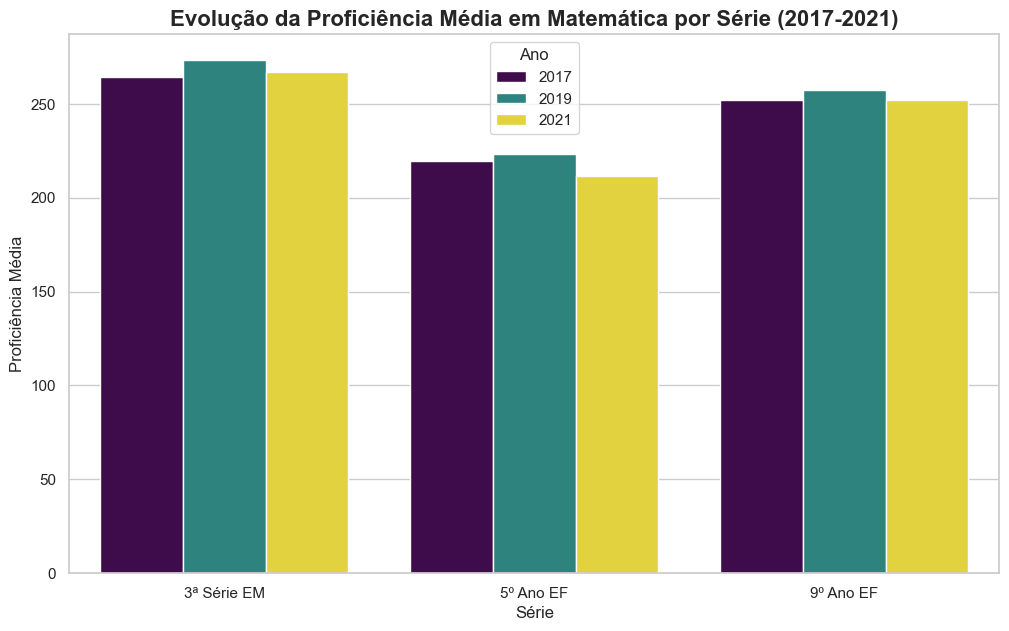

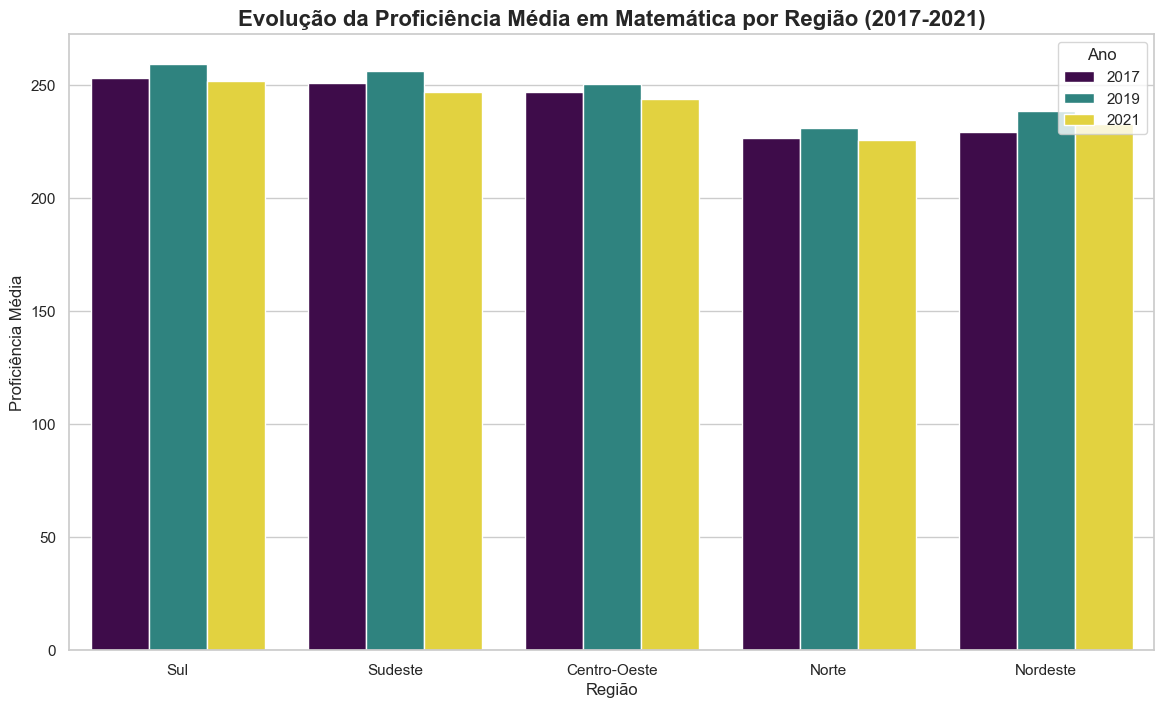

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir um estilo e uma paleta de cores para os gráficos
sns.set_theme(style="whitegrid")
palette = "viridis"

# --- Análise 1: Evolução da Proficiência Média por Série ---

# Agrupamos por ANO e SÉRIE para calcular a média
media_por_ano_serie = df_final.groupby(['ANO', 'SERIE'])['PROFICIENCIA'].mean().reset_index()

# Criando o gráfico de barras comparativo
plt.figure(figsize=(12, 7))
sns.barplot(data=media_por_ano_serie, x='SERIE', y='PROFICIENCIA', hue='ANO', palette=palette)

plt.title('Evolução da Proficiência Média em Matemática por Série (2017-2021)', fontsize=16, weight='bold')
plt.xlabel('Série', fontsize=12)
plt.ylabel('Proficiência Média', fontsize=12)
plt.legend(title='Ano')
plt.show()


# --- Análise 2: Evolução da Proficiência Média por Região ---

# Agrupamos por ANO e REGIÃO para calcular a média
media_por_ano_regiao = df_final.groupby(['ANO', 'REGIAO'])['PROFICIENCIA'].mean().reset_index()
# Ordenar as regiões para melhor visualização
ordem_regioes = ['Sul', 'Sudeste', 'Centro-Oeste', 'Norte', 'Nordeste']
media_por_ano_regiao['REGIAO'] = pd.Categorical(media_por_ano_regiao['REGIAO'], categories=ordem_regioes, ordered=True)
media_por_ano_regiao.sort_values('REGIAO', inplace=True)


# Criando o gráfico de barras comparativo
plt.figure(figsize=(14, 8))
sns.barplot(data=media_por_ano_regiao, x='REGIAO', y='PROFICIENCIA', hue='ANO', palette=palette)

plt.title('Evolução da Proficiência Média em Matemática por Região (2017-2021)', fontsize=16, weight='bold')
plt.xlabel('Região', fontsize=12)
plt.ylabel('Proficiência Média', fontsize=12)
plt.legend(title='Ano')
plt.show()